# Прекод

# Сборный проект-4

Вам поручено разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

### Описание данных

Данные доступны по [ссылке](https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip).

В файле `train_dataset.csv` находится информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `train_images` содержатся изображения для тренировки модели.

В файле `CrowdAnnotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.

3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

В файле `test_queries.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `test_images` содержатся изображения для тестирования модели.

In [33]:
from pathlib import Path
from PIL import Image
import re

import pandas as pd
import matplotlib.pyplot as plt
import spacy
import numpy as np
from tqdm import tqdm

from tensorflow.keras.layers import (Dense, GlobalAveragePooling2D, Flatten, Dropout, BatchNormalization)
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
#from tensorflow import keras
#import tensorflow as tf
import keras_nlp

tqdm.pandas()

In [3]:
RANDOM_STATE = 42
TRAIN_IMAGES_PATH = Path('data', 'train_images')
TEST_IMAGES_PATH = Path('data', 'test_images')
CHILDREN_STOPWORDS = [
    'baby', 'infant', 'newborn', 'toddler','child',
    'kid', 'boy', 'girl', 'children', 'teenager',
]
SPACY_NLP = spacy.load('en_core_web_sm')

In [4]:
def get_dataset_info(df):
    print(f'Датасет - {df.name}')
    print('''
        _____________________________________________
        |      Справочная информация о датасете     |
        _____________________________________________
        ''')
    df.info()
    print('''
        _____________________________________
        |      Первые 5 строк датасетат     |
        _____________________________________
        ''')
    display(df.head())
    print('''
        __________________________________
        |      Количество дубликатов     |
        __________________________________
        ''')
    print(df.duplicated().sum())
    print('____________________________________________________________________________________')

## 1. Загрузка и предобработка данных

In [5]:
try:
    train_df = pd.read_csv('data/train_dataset.csv')
    train_df.name = 'train_dataset'
    test_queries_df = pd.read_csv('data/test_queries.csv', sep='|', index_col=0)
    test_queries_df.name = 'test_queries_df'
    crowd_annotations_df = pd.read_csv(
        'data/CrowdAnnotations.tsv', sep='\t', header=None,
        names=['image', 'query_id', 'fraction', 'count_match', 'count_not_match']
    )
    crowd_annotations_df.name = 'CrowdAnnotations'
    expert_annotations_df = pd.read_csv(
        'data/ExpertAnnotations.tsv', sep='\t', header=None,
        names=['image', 'query_id', 'expert_1', 'expert_2', 'expert_3']
    )
    expert_annotations_df.name = 'ExpertAnnotations'
except Exception as e:
    print(f'Один из файлов не найден: \n{e}')

## 1. Исследовательский анализ данных

Наш датасет содержит экспертные и краудсорсинговые оценки соответствия текста и изображения.

В файле с экспертными мнениями для каждой пары изображение-текст имеются оценки от трёх специалистов. Для решения задачи вы должны эти оценки агрегировать — превратить в одну. Существует несколько способов агрегации оценок, самый простой — голосование большинства: за какую оценку проголосовала большая часть экспертов (в нашем случае 2 или 3), та оценка и ставится как итоговая. Поскольку число экспертов меньше числа классов, может случиться, что каждый эксперт поставит разные оценки, например: 1, 4, 2. В таком случае данную пару изображение-текст можно исключить из датасета.

Вы можете воспользоваться другим методом агрегации оценок или придумать свой.

В файле с краудсорсинговыми оценками информация расположена в таком порядке:

1. Доля исполнителей, подтвердивших, что текст **соответствует** картинке.
2. Количество исполнителей, подтвердивших, что текст **соответствует** картинке.
3. Количество исполнителей, подтвердивших, что текст **не соответствует** картинке.

После анализа экспертных и краудсорсинговых оценок выберите либо одну из них, либо объедините их в одну по какому-то критерию: например, оценка эксперта принимается с коэффициентом 0.6, а крауда — с коэффициентом 0.4.

Ваша модель должна возвращать на выходе вероятность соответствия изображения тексту, поэтому целевая переменная должна иметь значения от 0 до 1.


In [6]:
for df in [train_df, test_queries_df, crowd_annotations_df, expert_annotations_df]:
    get_dataset_info(df)

Датасет - train_dataset

        _____________________________________________
        |      Справочная информация о датасете     |
        _____________________________________________
        
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB

        _____________________________________
        |      Первые 5 строк датасетат     |
        _____________________________________
        


,image,query_id,query_text
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...



        __________________________________
        |      Количество дубликатов     |
        __________________________________
        
0
____________________________________________________________________________________
Датасет - test_queries_df

        _____________________________________________
        |      Справочная информация о датасете     |
        _____________________________________________
        
<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    500 non-null    object
 1   query_text  500 non-null    object
 2   image       500 non-null    object
dtypes: object(3)
memory usage: 15.6+ KB

        _____________________________________
        |      Первые 5 строк датасетат     |
        _____________________________________
        


,query_id,query_text,image
0,1177994172_10d143cb8d.jpg#0,"Two blonde boys , one in a camouflage shirt an...",1177994172_10d143cb8d.jpg
1,1177994172_10d143cb8d.jpg#1,Two boys are squirting water guns at each other .,1177994172_10d143cb8d.jpg
2,1177994172_10d143cb8d.jpg#2,Two boys spraying each other with water,1177994172_10d143cb8d.jpg
3,1177994172_10d143cb8d.jpg#3,Two children wearing jeans squirt water at eac...,1177994172_10d143cb8d.jpg
4,1177994172_10d143cb8d.jpg#4,Two young boys are squirting water at each oth...,1177994172_10d143cb8d.jpg



        __________________________________
        |      Количество дубликатов     |
        __________________________________
        
0
____________________________________________________________________________________
Датасет - CrowdAnnotations

        _____________________________________________
        |      Справочная информация о датасете     |
        _____________________________________________
        
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   image            47830 non-null  object 
 1   query_id         47830 non-null  object 
 2   fraction         47830 non-null  float64
 3   count_match      47830 non-null  int64  
 4   count_not_match  47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB

        _____________________________________
        |      Первые 5 строк датасе

,image,query_id,fraction,count_match,count_not_match
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.0,3,0
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.0,0,3
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,0.0,0,3
3,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,0.0,0,3
4,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,0.0,0,3



        __________________________________
        |      Количество дубликатов     |
        __________________________________
        
0
____________________________________________________________________________________
Датасет - ExpertAnnotations

        _____________________________________________
        |      Справочная информация о датасете     |
        _____________________________________________
        
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image     5822 non-null   object
 1   query_id  5822 non-null   object
 2   expert_1  5822 non-null   int64 
 3   expert_2  5822 non-null   int64 
 4   expert_3  5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.6+ KB

        _____________________________________
        |      Первые 5 строк датасетат     |
        _____________________________________
        


,image,query_id,expert_1,expert_2,expert_3
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2



        __________________________________
        |      Количество дубликатов     |
        __________________________________
        
0
____________________________________________________________________________________


Датасет - `train_images` содержит 5822 строки. Пропусков и дубликатов нет  
Датасет - `test_images` содержит 500 строки. Пропусков и дубликатов нет  
Датасет с оценками краудсорсинговыми оценками `CrowdAnnotations` содержит 47830 сток. Пропусков и дубликатов нет  
Датасет с оценками экспертов `ExpertAnnotations` содержит 5822 строк. Пропусков и дубликатов нет

Объединим датасат для обучения с оценками экпертов и краудсорсинговыми оценками

In [7]:
train_df_with_annotations = (
    train_df
    .merge(expert_annotations_df, on=['image', 'query_id'], how='left')
    .merge(crowd_annotations_df, on=['image', 'query_id'], how='left')
)

In [8]:
train_df_with_annotations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   image            5822 non-null   object 
 1   query_id         5822 non-null   object 
 2   query_text       5822 non-null   object 
 3   expert_1         5822 non-null   int64  
 4   expert_2         5822 non-null   int64  
 5   expert_3         5822 non-null   int64  
 6   fraction         2329 non-null   float64
 7   count_match      2329 non-null   float64
 8   count_not_match  2329 non-null   float64
dtypes: float64(3), int64(3), object(3)
memory usage: 409.5+ KB


Можно заметить, что для каждого изображения из тренировочного датасета есть оценки экспертов, однако краудсорсинговая оценка есть только для 2329 изображений

Посмотрим на изображения из тренировочного датасета с оценками

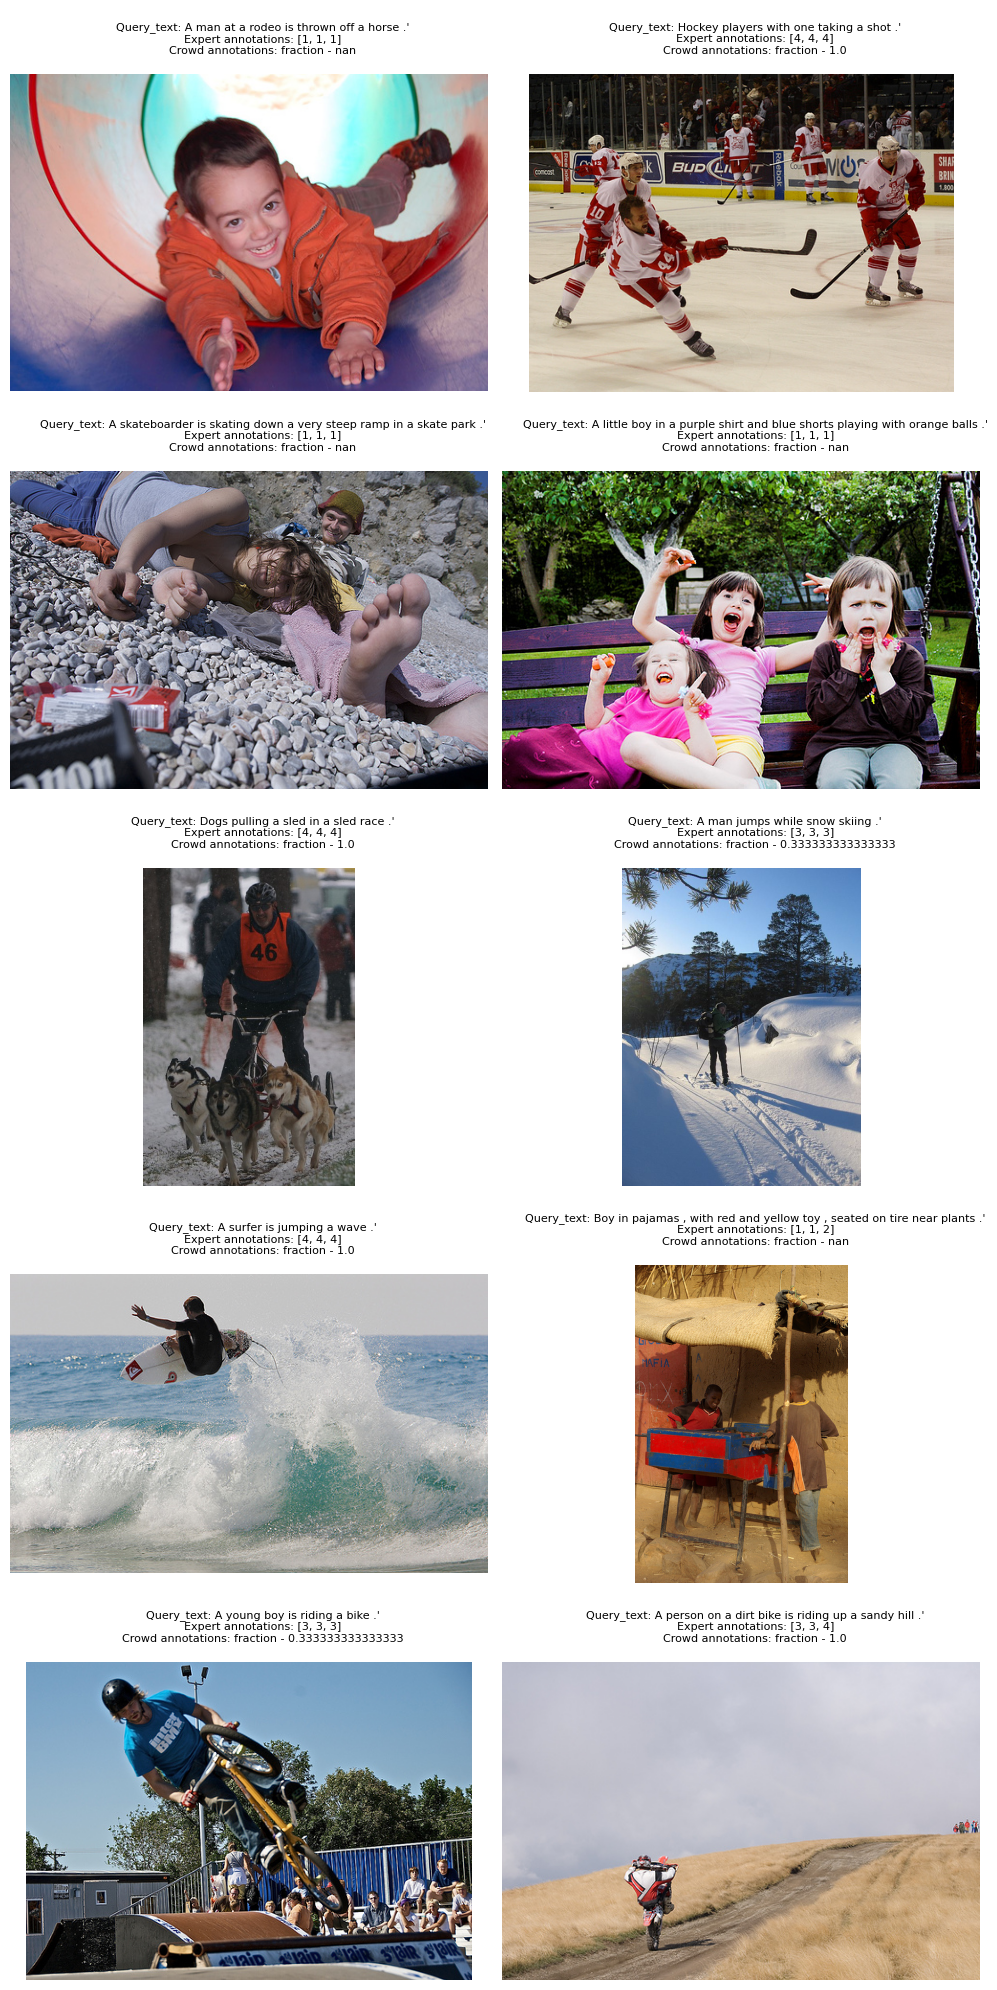

In [9]:
subsampling = train_df_with_annotations.sample(10, random_state=RANDOM_STATE)
fig = plt.figure(figsize=(10, 20))
for i in range(10):
    row = subsampling.iloc[i]
    img = Image.open(
        TRAIN_IMAGES_PATH / row['image']
    )
    fig.add_subplot(5, 2, i+1)
    plt.imshow(img)
    plt.title(
        f'''
        Query_text: {row["query_text"]}'
        Expert annotations: [{row["expert_1"]}, {row["expert_2"]}, {row["expert_3"]}]
        Crowd annotations: fraction - {row['fraction']}
        ''',
        fontdict={'fontsize': 8}
    )
    plt.axis('off')
    plt.tight_layout()

Исследуем оценки экспертов. Для выведения общей оценки возьмем среднюю оценку всех экспертов

Посмотрим на распределение средней оценки экспертов

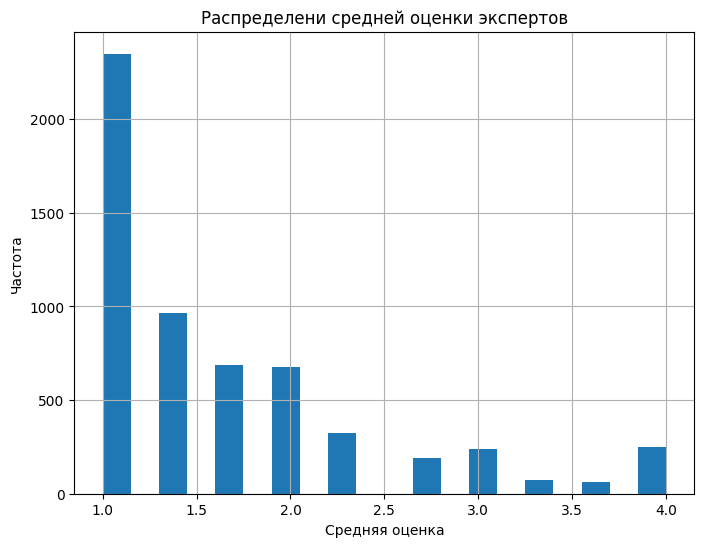

In [10]:
_, ax = plt.subplots(figsize=(8, 6))
ax.hist(
    expert_annotations_df[['expert_1', 'expert_2', 'expert_3']].mean(axis=1),
    bins=20
)
ax.set_title('Распределени средней оценки экспертов')
ax.set_xlabel('Средняя оценка')
ax.set_ylabel('Частота')
ax.grid(True)
plt.show()

Из гистограммы видно, что в тренировочном датасете в основном находятся изображения, которые не соответствуют описанию. Преобладает средняя оценка - 1

Исследуем краудсорсинговые оценки

In [11]:
crowd_annotations_df['all_count'] = crowd_annotations_df['count_match'] + crowd_annotations_df['count_not_match']

In [12]:
crowd_annotations_df['all_count'].value_counts()

all_count
3    46780
4      780
5      220
6       50
Name: count, dtype: int64

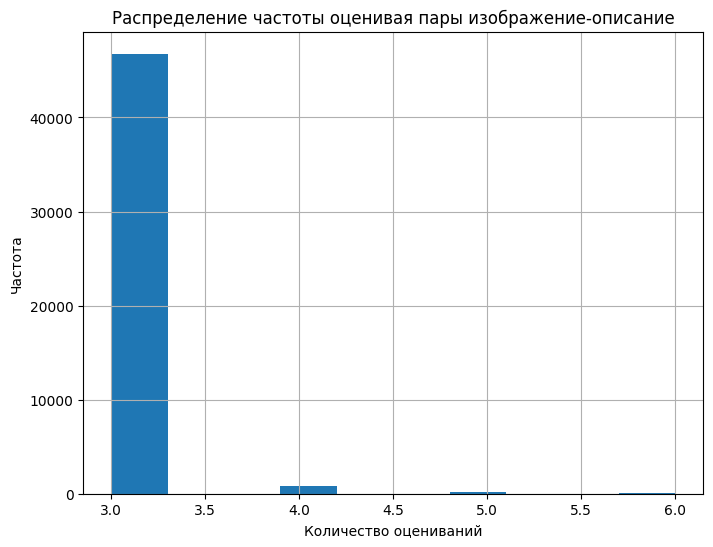

In [13]:
_, ax = plt.subplots(figsize=(8, 6))
ax.hist(crowd_annotations_df['all_count'])
ax.set_title('Распределение частоты оценивая пары изображение-описание')
ax.set_xlabel('Количество оцениваний')
ax.set_ylabel('Частота')
ax.grid(True)
plt.show()

Можно заметить, что почти все пары `изображение-описание` оценены лишь 3 людьми. Это крайне мало для данного вида оценки, чтобы можно было доверять этим данным. Поэтому для обучения моделей не будем использовать краудорсинговые оценки

**Вывод:**  
Получено представление об имеющихся данных: у нас есть 5822 пары `изображение-описание`, оцененные экспертами и 47830 пары `изображение-описание` c краудорсинговыми оценками. Несмотря на большой объем данных в краудсорсинговых оценках их качество вызывает сомнения, так как основное количество пар оценено лишь 3 людьми, что крайне мало для такого вида оценки, чтобы опираться на него. В итоге для обучения моделей будем использовать только экспертные оценки

## 2. Предобработка данных

Добавим к тренировочному датасету оценки экспертов. Посчитаем среднюю оценку и переведем ее в диапазон от 0 до 1

In [14]:
train_df = train_df.merge(
    expert_annotations_df,
    on=['image', 'query_id'],
    how='left',
)

In [15]:
train_df['target'] = round(
    (train_df[['expert_1', 'expert_2', 'expert_3']].mean(axis=1) - 1) / 3.,
    3
)

In [16]:
train_df.head()

,image,query_id,query_text,expert_1,expert_2,expert_3,target
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,1,1,1,0.000
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,1,1,1,0.000
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,1,2,2,0.222
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,4,4,4,1.000
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,1,1,1,0.000


Столбцы `query_id`, `expert_1`, `expert_2`, `expert_3` не понадобятся для обучения моделей. Удалим их

In [17]:
train_df.drop(['query_id', 'expert_1', 'expert_2', 'expert_3'], axis=1, inplace=True)

## 3. Проверка данных

В некоторых странах, где работает ваша компания, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет.

В вашем сервисе строго следуют законам стран, в которых работают. Поэтому при попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:

> This image is unavailable in your country in compliance with local laws
>

Однако у вас в PoC нет возможности воспользоваться данным функционалом. Поэтому все изображения, которые нарушают данный закон, нужно удалить из обучающей выборки.

In [18]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[']", "", text)
    text = re.sub(r"[^\w]", " ", text)
    text = ' '.join(text.split())
    return text

In [19]:
def lemmatize(text, nlp):
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc]).lower()

In [20]:
def clean_and_lemmatize(text, nlp):
    text = clean_text(text)
    return lemmatize(text, nlp)

In [21]:
train_df['query_lemmatized'] = train_df['query_text'].progress_apply(clean_and_lemmatize, nlp=SPACY_NLP)

100%|██████████| 5822/5822 [01:12<00:00, 80.04it/s] 


Определяем, есть ли в запросе запрещенные слова

In [22]:
train_df['is_forbidden_request'] = train_df['query_lemmatized'].progress_apply(
    lambda text, stopwords: any([word in text.split() for word in stopwords]),
    stopwords=CHILDREN_STOPWORDS
)

100%|██████████| 5822/5822 [00:00<00:00, 56356.94it/s]


Удаляем отобранные запросы

In [23]:
train_df = train_df.query('not is_forbidden_request')

In [24]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4263 entries, 22 to 5821
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   image                 4263 non-null   object 
 1   query_text            4263 non-null   object 
 2   target                4263 non-null   float64
 3   query_lemmatized      4263 non-null   object 
 4   is_forbidden_request  4263 non-null   bool   
dtypes: bool(1), float64(1), object(3)
memory usage: 170.7+ KB


**Вывод**:
Из обучающей выборки были удалены запросы, содержащие упоминания детей. В итоге в датасете осталось 4263 строки из первоначальных 5822.

## 3. Векторизация изображений

Перейдём к векторизации изображений.

Самый примитивный способ — прочесть изображение и превратить полученную матрицу в вектор. Такой способ нам не подходит: длина векторов может быть сильно разной, так как размеры изображений разные. Поэтому стоит обратиться к свёрточным сетям: они позволяют "выделить" главные компоненты изображений. Как это сделать? Нужно выбрать какую-либо архитектуру, например ResNet-18, посмотреть на слои и исключить полносвязные слои, которые отвечают за конечное предсказание. При этом можно загрузить модель данной архитектуры, предварительно натренированную на датасете ImageNet.

In [25]:
def create_cv_model(input_shape=(224, 224, 3)):
    backbone = ResNet50(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet'
    )
    backbone.trainable = False

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.0001), metrics=['mae'])

    return model

In [26]:
def image2vector(model, images):
    return model.predict(images)

In [27]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen_flow = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=TRAIN_IMAGES_PATH,
    x_col='image',
    y_col='target',
    target_size=(224, 224),
    batch_size=32,
    class_mode='input',
    shuffle=False,
    seed=RANDOM_STATE
)

Found 4263 validated image filenames.


In [28]:
model_resnet50 = create_cv_model()

In [29]:
image_embeddings = image2vector(model_resnet50, train_gen_flow)

image_embeddings.shape

c:\Data\practicum\data_science\with_sense_photo_search\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


134/134 ━━━━━━━━━━━━━━━━━━━━ 482s 4s/step


(4263, 2048)

In [ ]:
print(f'''Векторизация изображения на основе модели resnet50 позволило получить вектор длинной {image_embeddings[0].shape[0]}
Уменьшение вектора позволит сэкономить ресурсы и вычислительное время при обучении.''')

Векторизация изображения на основе модели resnet50 позволило получить вектор длинной 2048
Уменьшение вектора позволит сэкономить ресурсы и вычислительное время при обучении.


## 4. Векторизация текстов

Следующий этап — векторизация текстов. Вы можете поэкспериментировать с несколькими способами векторизации текстов:

- tf-idf
- word2vec
- \*трансформеры (например Bert)

\* — если вы изучали трансформеры в спринте Машинное обучение для текстов.


In [32]:
preprocessor_bert = keras_nlp.models.BertPreprocessor.from_preset('bert_base_en')

AttributeError: module 'keras_nlp' has no attribute 'models'

In [34]:
model_bert = keras_nlp.models.BertBackbone.from_preset('bert_base_en')

AttributeError: module 'keras_nlp' has no attribute 'models'

In [ ]:
def vectorize_text(model, preprocessor, data, batch_size=32):
    embeddings = []
    tokenized = preprocessor(data)

    for i in tqdm(range(tokenized['token_ids'].shape[0] // batch_size + 1)):

        tokens = tokenized['token_ids'][batch_size*i:batch_size*(i+1)]
        token_types = tokenized['segment_ids'][batch_size*i:batch_size*(i+1)]
        mask = tokenized['padding_mask'][batch_size*i:batch_size*(i+1)]

        batch = {
            'token_ids' : tokens,
            'segment_ids' : token_types,
            'padding_mask' : mask
        }

        batch_embeddings = model.predict(batch)

        embeddings.append(batch_embeddings['pooled_output'])

    return np.concatenate(embeddings)

In [ ]:
text_embeds = vectorize_text(model=bert, data=text)

In [ ]:
model_bert = AutoModel.from_pretrained('unitary/toxic-bert')
tokenizer_bert = AutoTokenizer.from_pretrained('unitary/toxic-bert')

tokenized = train_df['text'].apply(
    lambda x: tokenizer_bert.encode(x, add_special_tokens=True, max_length=512, truncation=True)
)

max_len = 0
for i in tokenized.values:
    max_len = max(max_len, len(i))

padded = np.array([i + [0] * (max_len - len(i)) for i in tokenized.values])
attention_mask = np.where(padded != 0, 1, 0)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

batch_size = 128
embeddings = []
for i in tqdm(range(padded.shape[0] // batch_size + 1)):
    batch = torch.LongTensor(padded[i * batch_size : (i + 1) * batch_size]).to(device)
    attention_mask_batch = torch.LongTensor(attention_mask[i * batch_size : (i + 1) * batch_size]).to(device)
    
    with torch.no_grad():
        batch_embeddings = model(batch, attention_mask=attention_mask_batch)
        embeddings.append(batch_embeddings[0][:,0,:].cpu().numpy())
torch.cuda.empty_cache()

features = pd.DataFrame(np.concatenate(embeddings))
features['count_words'] = data['count_words']
target = data['toxic']

## 5. Объединение векторов

Подготовьте данные для обучения: объедините векторы изображений и векторы текстов с целевой переменной.

## 6. Обучение модели предсказания соответствия

Для обучения разделите датасет на тренировочную и тестовую выборки. Простое случайное разбиение не подходит: нужно исключить попадание изображения и в обучающую, и в тестовую выборки.
Для того чтобы учесть изображения при разбиении, можно воспользоваться классом [GroupShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupShuffleSplit.html) из библиотеки sklearn.model_selection.

Код ниже разбивает датасет на тренировочную и тестовую выборки в пропорции 7:3 так, что строки с одинаковым значением 'group_column' будут содержаться либо в тестовом, либо в тренировочном датасете.

```
from sklearn.model_selection import GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
train_indices, test_indices = next(gss.split(X=df.drop(columns=['target']), y=df['target'], groups=df['group_column']))
train_df, test_df = df.loc[train_indices], df.loc[test_indices]

```

Какую модель использовать — выберите самостоятельно. Также вам предстоит выбрать метрику качества либо реализовать свою.

## 7. Тестирование модели

Настало время протестировать модель. Для этого получите эмбеддинги для всех тестовых изображений из папки `test_images`, выберите случайные 10 запросов из файла `test_queries.csv` и для каждого запроса выведите наиболее релевантное изображение. Сравните визуально качество поиска.

## 8. Выводы

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Исследовательский анализ данных выполнен
- [ ]  Проверены экспертные оценки и краудсорсинговые оценки
- [ ]  Из датасета исключены те объекты, которые выходят за рамки юридических ограничений
- [ ]  Изображения векторизованы
- [ ]  Текстовые запросы векторизованы
- [ ]  Данные корректно разбиты на тренировочную и тестовую выборки
- [ ]  Предложена метрика качества работы модели
- [ ]  Предложена модель схожести изображений и текстового запроса
- [ ]  Модель обучена
- [ ]  По итогам обучения модели сделаны выводы
- [ ]  Проведено тестирование работы модели
- [ ]  По итогам тестирования визуально сравнили качество поиска